In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

In [2]:
varname_to_hr = {"forecast_demand_24h": 24,
                 "forecast_demand_18h": 18,
                 "forecast_demand_12h": 12,
                 "forecast_demand_6h": 6}

df_forecast_interval = pd.read_csv('data/forecast_intervals.csv')
df_forecast_interval.date_time_future = pd.to_datetime(df_forecast_interval.date_time_future, format = "%Y-%m-%d %H:%M:%S")

df_temperature = pd.read_csv('data/temperature_nsw.csv', names = ['location', 'date_time', 'temperature'], skiprows = 1)
df_temperature.date_time = pd.to_datetime(df_temperature.date_time, format = "%d/%m/%Y %H:%M")

df_demand = pd.read_csv('data/totaldemand_nsw.csv', names = ['date_time', 'total_demand', 'region_id'], skiprows = 1)
df_demand.date_time = pd.to_datetime(df_demand.date_time, format = "%d/%m/%Y %H:%M")

df_forecast_interval_long = df_forecast_interval.copy().melt(id_vars = "date_time_future", var_name = "foreceast_interval", value_name = "demand_forecast")
df_forecast_interval_long.foreceast_interval = df_forecast_interval_long.foreceast_interval.map(varname_to_hr)
df_forecast_interval_long["foreceast_interval_dt"] = pd.to_timedelta(df_forecast_interval_long.foreceast_interval,'h')
df_forecast_interval_long["date_time_current"] = df_forecast_interval_long.date_time_future - df_forecast_interval_long.foreceast_interval_dt

In [3]:
df_forecast = pd.merge(df_forecast_interval_long, df_temperature, left_on = "date_time_current", right_on = "date_time")
df_forecast = df_forecast.drop(columns = ["date_time", "location"]).rename({"temperature": "temperature_current"}, axis = 1)

df_forecast = pd.merge(df_forecast, df_temperature, left_on = "date_time_future", right_on = "date_time")
df_forecast = df_forecast.drop(columns = ["date_time", "location"]).rename({"temperature": "temperature_future"}, axis = 1)

df_forecast = pd.merge(df_forecast, df_demand, left_on = "date_time_future", right_on = "date_time")
df_forecast = df_forecast.drop(columns = ["date_time", "region_id"])

df_forecast["demand_error"] = df_forecast.total_demand - df_forecast.demand_forecast
df_forecast["demand_error_relative"] = (df_forecast.total_demand - df_forecast.demand_forecast)/df_forecast.total_demand

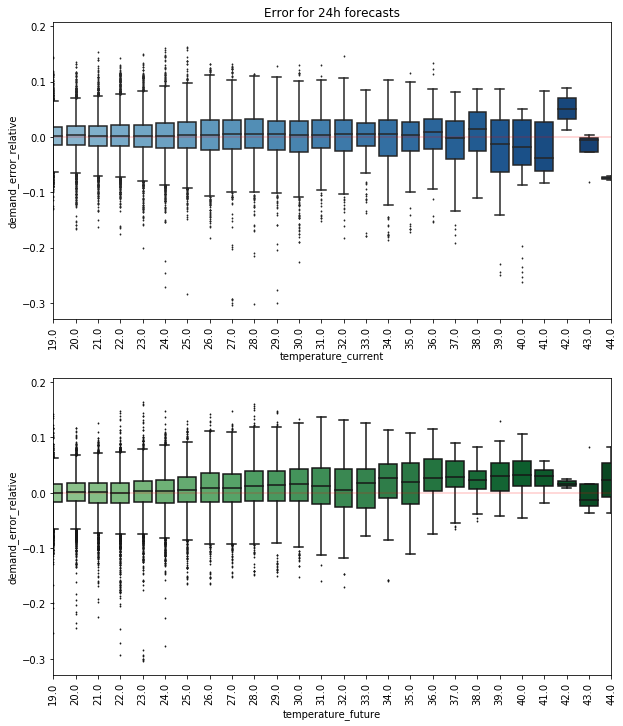

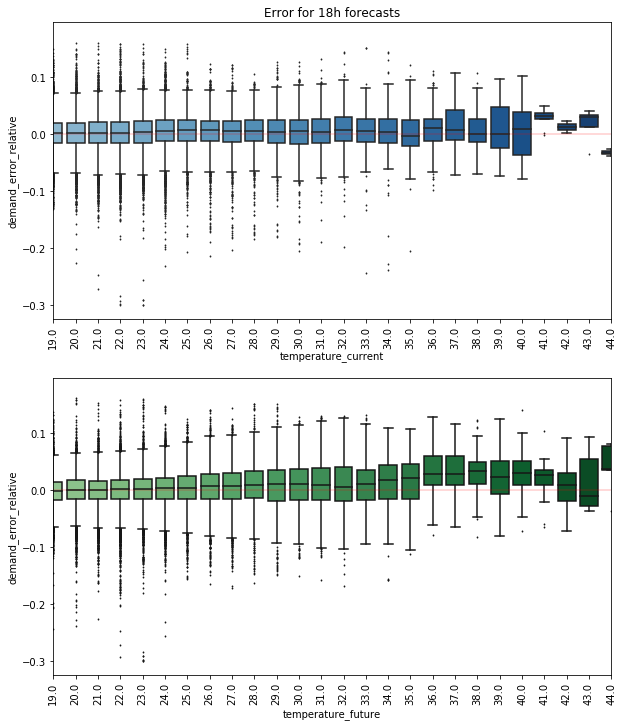

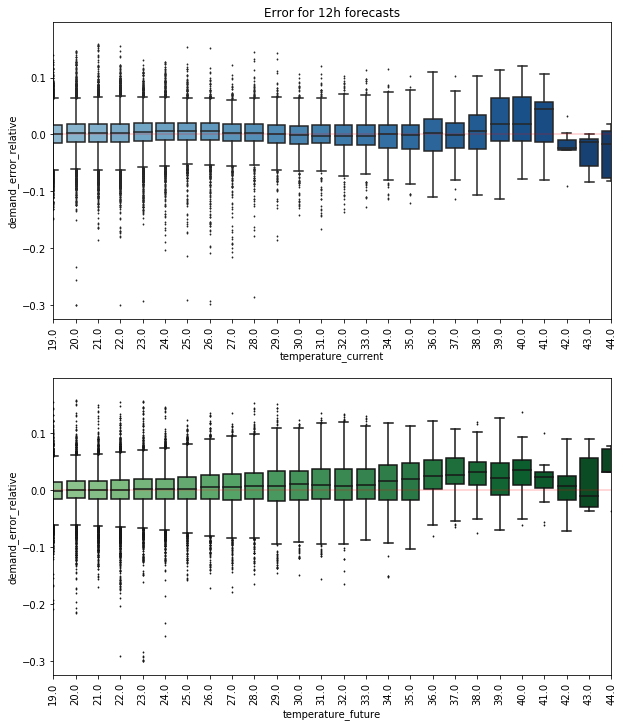

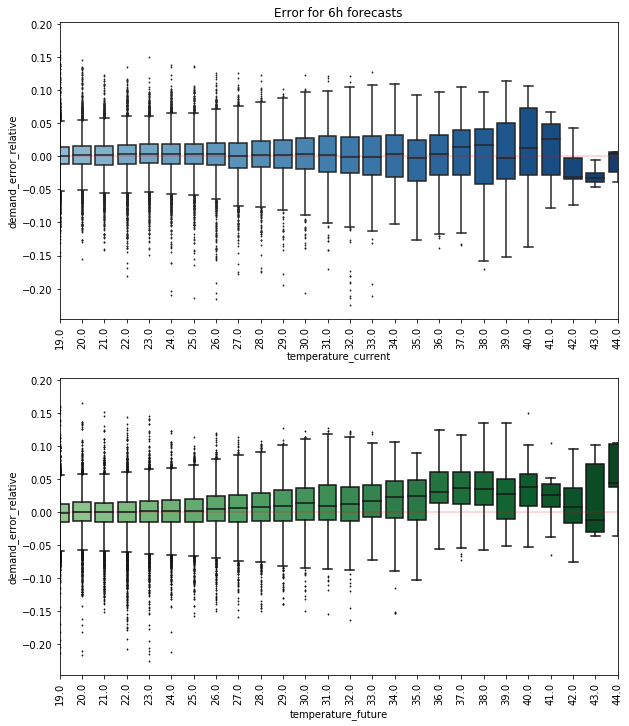

In [4]:
temp_cutoff_min = 20

for forecast_interval in set(df_forecast.foreceast_interval):
    df_plot = df_forecast.loc[df_forecast.foreceast_interval == forecast_interval]
    df_plot.temperature_current, df_plot.temperature_future = df_plot.temperature_current.round(0), df_plot.temperature_future.round(0)

    plt.figure(figsize = (10,12))
    plt.subplot(2,1,1)
    sns.boxplot(data=df_plot, x="temperature_current", y="demand_error_relative", palette = 'Blues', fliersize = 1)
    plt.axhline(0, color='r', alpha = 0.2)
    plt.xticks(rotation = 90);
    plt.title("Error for {}h forecasts".format(forecast_interval))
    plt.xlim(temp_cutoff_min, 45)

    plt.subplot(2,1,2)
    sns.boxplot(data=df_plot, x="temperature_future", y="demand_error_relative", palette = 'Greens', fliersize = 1)
    plt.axhline(0, color='r', alpha = 0.2)
    plt.xticks(rotation = 90);
    plt.xlim(temp_cutoff_min, 45)